<a href="https://colab.research.google.com/github/Claptar/play_around_find_out/blob/main/statistics/chi2_sum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set the environment

## Install packages

These packages needed for equation rendering in `matplotlib`

In [ ]:
!sudo apt install -qqq cm-super dvipng texlive-latex-extra texlive-latex-recommended

## Import packages

In [2]:
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

sns.set_theme(style="white")

## Helper functions

In [3]:
def odd_subplots(num=3, figsize=(12, 6), gridspec_kw=None):
    col_num = num // 2
    # ------------------------------------------------------------------
    # 1 – regular 2×3 grid
    # ------------------------------------------------------------------
    fig, ax = plt.subplots(
        2, col_num,
        figsize=figsize,           # scale to taste
        gridspec_kw=gridspec_kw
    )

    # ------------------------------------------------------------------
    # 2 – locate the spare space on the right
    # ------------------------------------------------------------------
    # use any of the existing axes as the size template
    bbox      = ax[0, 0].get_position(fig)
    cell_w    = bbox.width
    cell_h    = bbox.height

    # horizontal gap already being used between the 1st & 2nd columns
    gap_x = ax[0, 1].get_position(fig).x0 - bbox.x1

    # x‑coordinate just to the right of column 3
    x0 = ax[0, 2].get_position(fig).x1 + gap_x

    # vertical centre point between the two rows
    y_mid = (ax[0, 0].get_position(fig).y0 + ax[1, 0].get_position(fig).y1) / 2
    y0    = y_mid - cell_h / 2                     # bottom edge for the new axes

    # ------------------------------------------------------------------
    # 3 – add the extra, perfectly matching axes
    # ------------------------------------------------------------------
    axn = fig.add_axes([x0, y0, cell_w, cell_h])
    all_axes = ax.flatten().tolist() + [axn]
    return fig, all_axes

# Introduction

## Motivation
This notebook is inpired by the fact that sample variance for normaly distributed random variable $X$ is related to $\chi^2$ distribution in the following way:

\begin{equation}
\frac{\sum_{i=1}^n(X_i - \overline{X_n})^2}{\sigma^2} \sim \chi^2(n-1)\tag{1}
\end{equation}

Here I want to play around with $\chi^2$ distribution to gain more intuition. But before that, let's start with basic facts.


The $\chi^2$ (chi-squared) distribution is a continuous probability distribution that arises in statistics, most notably in hypothesis testing and confidence interval estimation. It is a special case of the Gamma distribution and is closely related to the Normal distribution.

## Definition and relation to Gamma distribution

The chi-squared distribution is a special case of the Gamma distribution. A random variable $X$ that follows a Gamma distribution with shape parameter $\alpha$ and scale parameter $\beta$ (or rate parameter $\theta = 1/\beta$) has the probability density function:

\begin{equation}
f(x; \alpha, \beta) = \frac{\beta^\alpha x^{\alpha - 1} e^{-\beta x}}{\Gamma(\alpha)} \quad \text{for } x > 0, \alpha > 0, \beta > 0 \tag{2}
\end{equation}

A chi-squared distribution with $k$ degrees of freedom is equivalent to a Gamma distribution with shape parameter $\alpha = k/2$ and scale parameter $\theta = 2$ (or rate parameter $\beta = 1/2$).

$$
\chi^2(k) \equiv \text{Gamma}(k/2, 1/2) \quad (\text{using rate parameter } \beta)
$$

This relationship is important as it allows us to use the properties and formulas of the Gamma distribution to understand and work with the chi-squared distribution.

## Relation to the Normal Distribution

If $Z_1, Z_2, \ldots, Z_k \sim \mathcal{N}(0,1)$ are $k$ independent standard normal random variables (with mean 0 and variance 1), then the sum of their squares is distributed according to the chi-squared distribution with $k$ degrees of freedom:

$$
\sum_{i=1}^k Z_i^2 \sim \chi^2(k) \tag{3}
$$

So degrees of freedom ($k$) represent the number of independent standard normal variables being summed


# Let's play around
## Another look at motivating example

If we take a close look at equation (1) we will see that

$$
\frac{\sum_{i=1}^n(X_i - \overline{X_n})^2}{\sigma^2} = \sum_{i=1}^n\Bigl(\frac{X_i - \overline{X_n}}{\sigma}\Bigr)^2 = \sum_{i=1}^nY_i^2. \tag{4}
$$

It's obvious that $Y_i$ has normal distribution, but to be exact let's find it's parameters.

$$
\mu_{Y_i} = \mathbb E[Y_i] = \mathbb E[X_i - \overline{X_n}] = 0, \\
\sigma^2_{Y_i} = \operatorname{Var}(Y_i) = \operatorname{Var}(X_i - \overline{X_n}) = \operatorname{Var}(X_i) + \operatorname{Var}(\overline{X_n}) - 2 \operatorname{Cov}(X_i,\overline{X_n}) = \operatorname{Var}(X_i) + \operatorname{Var}(\overline{X_n}) - 2 \operatorname{Cov}(X_i,\frac{X_i}{n}) = \sigma^2 + \frac{\sigma^2}{n} - 2\frac{\sigma^2}{n} = \frac{n-1}{n}\sigma^2.
$$

This means that $Y_i \sim \mathcal{N}(0,\frac{n-1}{n})$. ???~~Contrarily to equation (3) these variables are not independent, so the sum is being distributed as $\chi^2(n-1)$ instead of $\chi^2(n)$.~~??? This invites us to play around with correlated (in case of normal distribution correlation and independence are the same things) normal distributions.

## Make sure that relationship of $\chi^2$ to $\mathcal{N}$ truly holds

Before moving further let's see for ourselves that a sum of $k$ independent $\mathcal{N}(0,1)$ standart normal distributions truly have a $\chi^2(k)$ chi-squared distribution with $k$ degrees of freedom.

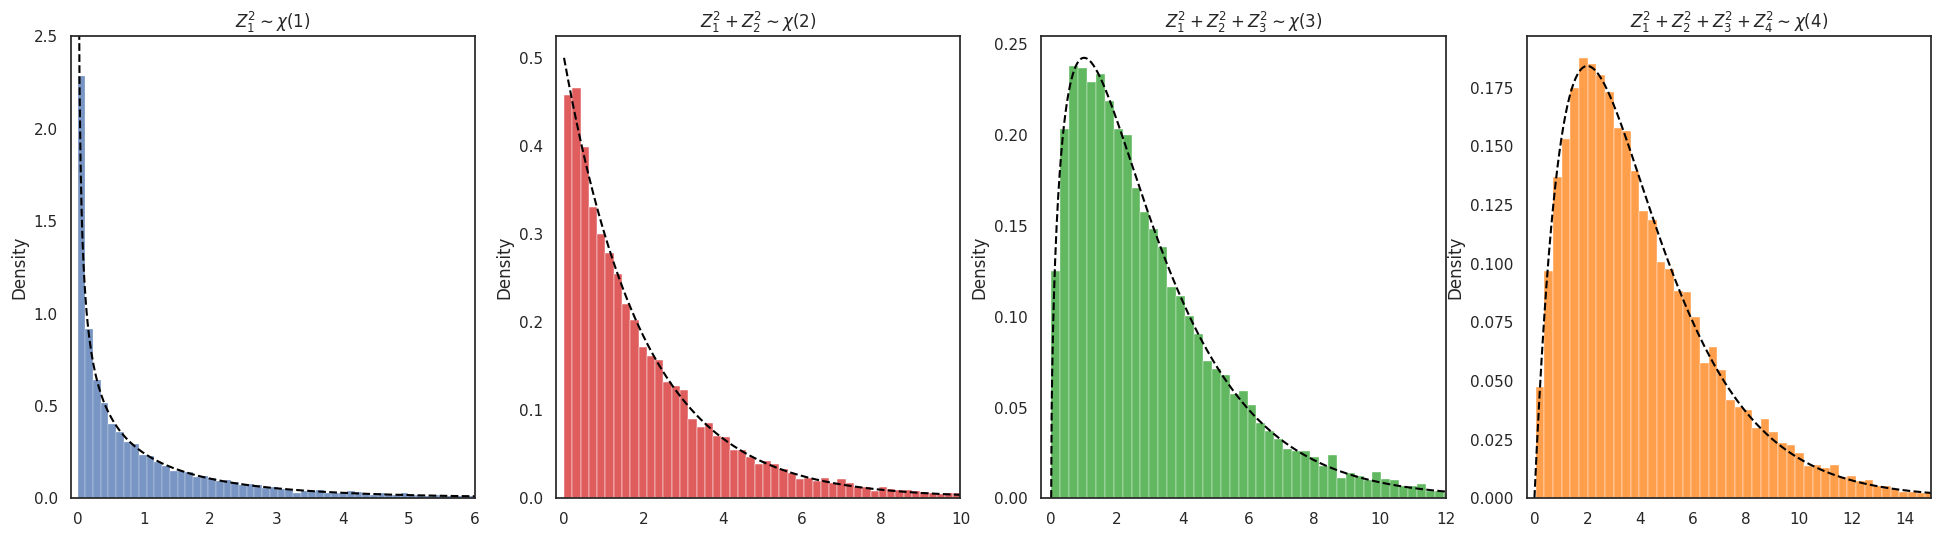

In [4]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 6), gridspec_kw={'wspace': 0.2})
t = np.linspace(0, 15, 1000)

# Generate 4 independent normal distributions
z = np.random.standard_normal((4, 10000))

# Find a square to convert N(0,1) -> chi(1) and sum them together
chi = (z ** 2).cumsum(axis=0)


# Plot histograms and densities
sns.histplot(chi[0, :], stat='density', ax=ax1)
ax1.plot(t, sp.stats.chi2.pdf(t, 1), linestyle='--', color='black')
ax1.set_title("$Z_1^2 \sim \chi$(1)")
ax1.set_xlim(-0.1, 6)
ax1.set_ylim(0, 2.5)


sns.histplot(chi[1, :], stat='density', ax=ax2, color='tab:red')
ax2.plot(t, sp.stats.chi2.pdf(t, 2), linestyle='--', color='black')
ax2.set_title("$Z_1^2 + Z_2^2 \sim \chi$(2)")
ax2.set_xlim(-0.2, 10)

sns.histplot(chi[2, :], stat='density', ax=ax3, color='tab:green')
ax3.plot(t, sp.stats.chi2.pdf(t, 3), linestyle='--', color='black')
ax3.set_title("$Z_1^2 + Z_2^2 + Z_3^2 \sim \chi$(3)")
ax3.set_xlim(-0.3, 12)

sns.histplot(chi[3, :], stat='density', ax=ax4, color='tab:orange')
ax4.plot(t, sp.stats.chi2.pdf(t, 4), linestyle='--', color='black')
ax4.set_title("$Z_1^2 + Z_2^2 + Z_3^2 + Z_4^2 \sim\chi$(4)")
ax4.set_xlim(-0.3, 15)

plt.show()

## Two correlated normal distributions

### Visualize

Okay, we noticed that the propertie (3) really holds, so now let's look at simple case of two random variables $X \sim \mathcal{N}(0,1)$ and $Y \sim \mathcal{N}(0,1)$ with correlation coeficient $\operatorname{corr}(X,Y)=r$.

In [5]:
# Generate X and Y variables
r = 0.8
x = np.random.standard_normal(10000)
y = np.random.normal(r * x, np.sqrt(1 - r ** 2))

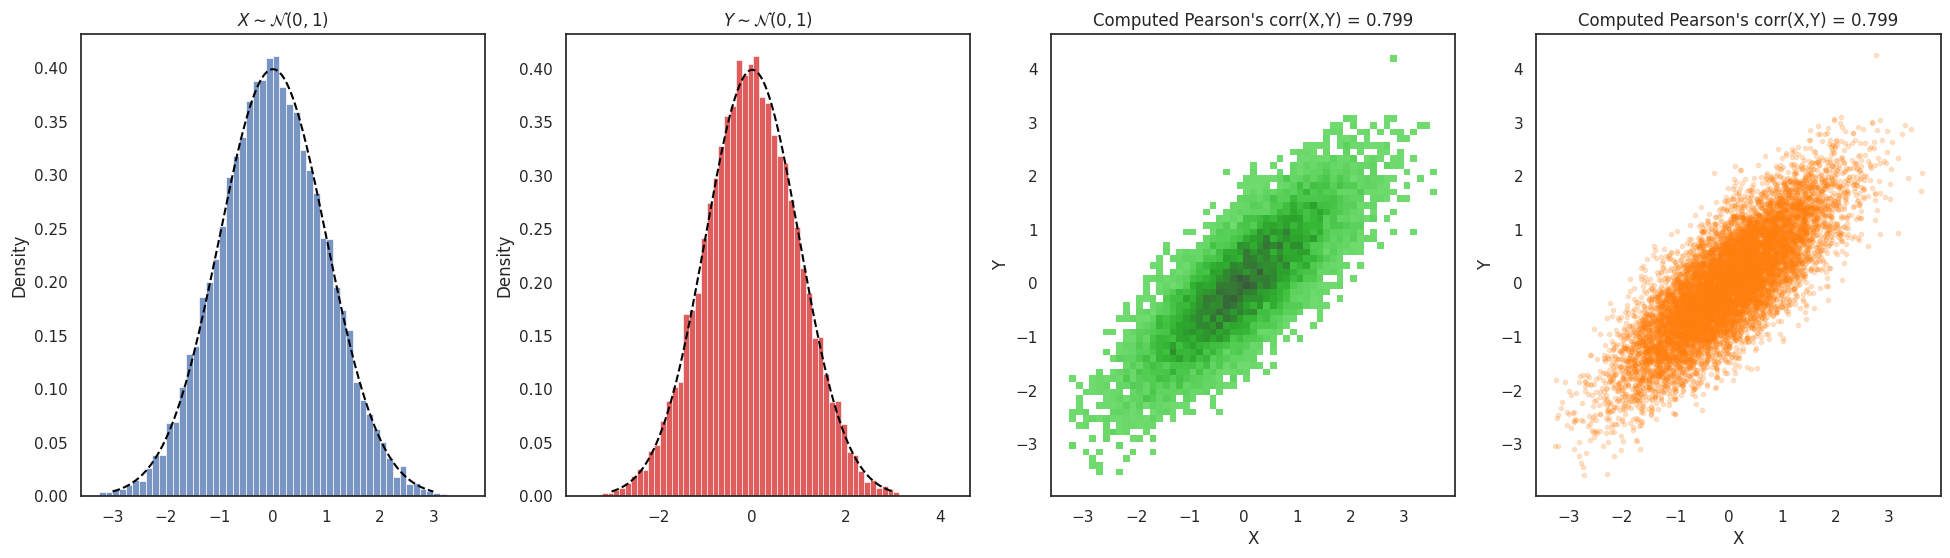

In [6]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 6), gridspec_kw={'wspace': 0.2})

# Calculate pdf for N(0, 1) distribution
t_norm = np.linspace(-3, 3, 1000)
normal_dist = sp.stats.norm.pdf(t_norm, 0, 1)

# Normal distribution
sns.histplot(x, stat='density', ax=ax1)
ax1.plot(t_norm, normal_dist, linestyle='--', color='black')
ax1.set_title("$X \sim \mathcal{N}(0, 1)$")

sns.histplot(y, stat='density', ax=ax2, color='tab:red')
ax2.plot(t_norm, normal_dist, linestyle='--', color='black')
ax2.set_title("$Y \sim \mathcal{N}(0, 1)$")

pearson = pearsonr(x, y).statistic
sns.histplot(x=x, y=y, ax=ax3, stat='density', color="tab:green")
ax3.set_title(f"Computed Pearson's corr(X,Y) = {pearson:.3f}")
ax3.set_xlabel("X")
ax3.set_ylabel("Y")

ax4.plot(x, y, '.', color="tab:orange", alpha=0.2)
ax4.set_title(f"Computed Pearson's corr(X,Y) = {pearson:.3f}")
ax4.set_xlabel("X")
ax4.set_ylabel("Y")

plt.show()

### Correlation of $\chi^2$ distributions

The first question we might ask is what value the correlation coefficient $corr(X^2, Y^2)$ takes. To answer it let's try constructing such random variables.

**1 Step.** Let's say that $X,Y\sim\mathcal N(0,1)$ and $\operatorname{corr}(X,Y)=r$. Then I want to figure out $\alpha$ and $Z\sim\mathcal N(0,\sigma_z^2)$ such that:

$$
Y=\alpha(X + Y), \\ \operatorname{corr}(X,Z)=0
$$

Basically we need to find $\sigma_z^2$ and $\alpha$. For that we need two independent equations. For example:

$$
\operatorname{Var}(Y) = \alpha^{2}\operatorname{Var}(X+Z)=\alpha^{2}\bigl(\operatorname{Var}(X)+\operatorname{Var}(Z)\bigr)
                       =\alpha^{2}\bigl(1+\operatorname{Var}(Z)\bigr), \\[4pt]
\operatorname{Cov}(X,Y) = \alpha\operatorname{Cov}(X,X)+\alpha\operatorname{Cov}(X,Z)=\alpha\cdot1+\alpha\cdot0=\alpha
$$

From these two equations we easily find that:

$$
r = \frac{\operatorname{Cov}(X,Y)}{\sqrt{\operatorname{Var}(X)\operatorname{Var}(Y)}}
     = \frac{\alpha}{\sqrt{1\cdot\alpha^{2}(1+\operatorname{Var}(Z))}}
     \;\;\Longrightarrow\;\; \alpha=r, \\[4pt]
1 = r^{2}\bigl(1+\operatorname{Var}(Z)\bigr)
     \;\;\Longrightarrow\;\; \operatorname{Var}(Z)=\frac{1-r^{2}}{r^{2}}
     \quad\Rightarrow\quad Z\sim\mathcal N\!\Bigl(0,\tfrac{1-r^{2}}{r^{2}}\Bigr).
$$

**2 Step.** Now we can find the correlation coeficient $\operatorname{corr}(X^2,Y^2)$ directly.

$$
\operatorname{corr}(X^{2},Y^{2})
  = \frac{\operatorname{Cov}(X^{2},Y^{2})}
          {\sqrt{\operatorname{Var}(X^{2})\,\operatorname{Var}(Y^{2})}}
  = \frac{\mathbb E\bigl[X^{2}Y^{2}\bigr]-\mathbb E[X^{2}]\,\mathbb E[Y^{2}]}
          {\sqrt{\operatorname{Var}(X^{2})\,\operatorname{Var}(Y^{2})}}
   = \frac{2r^{2}}{\sqrt{2\cdot2}}
   = r^{2}.
$$

Now let's check it computationaly

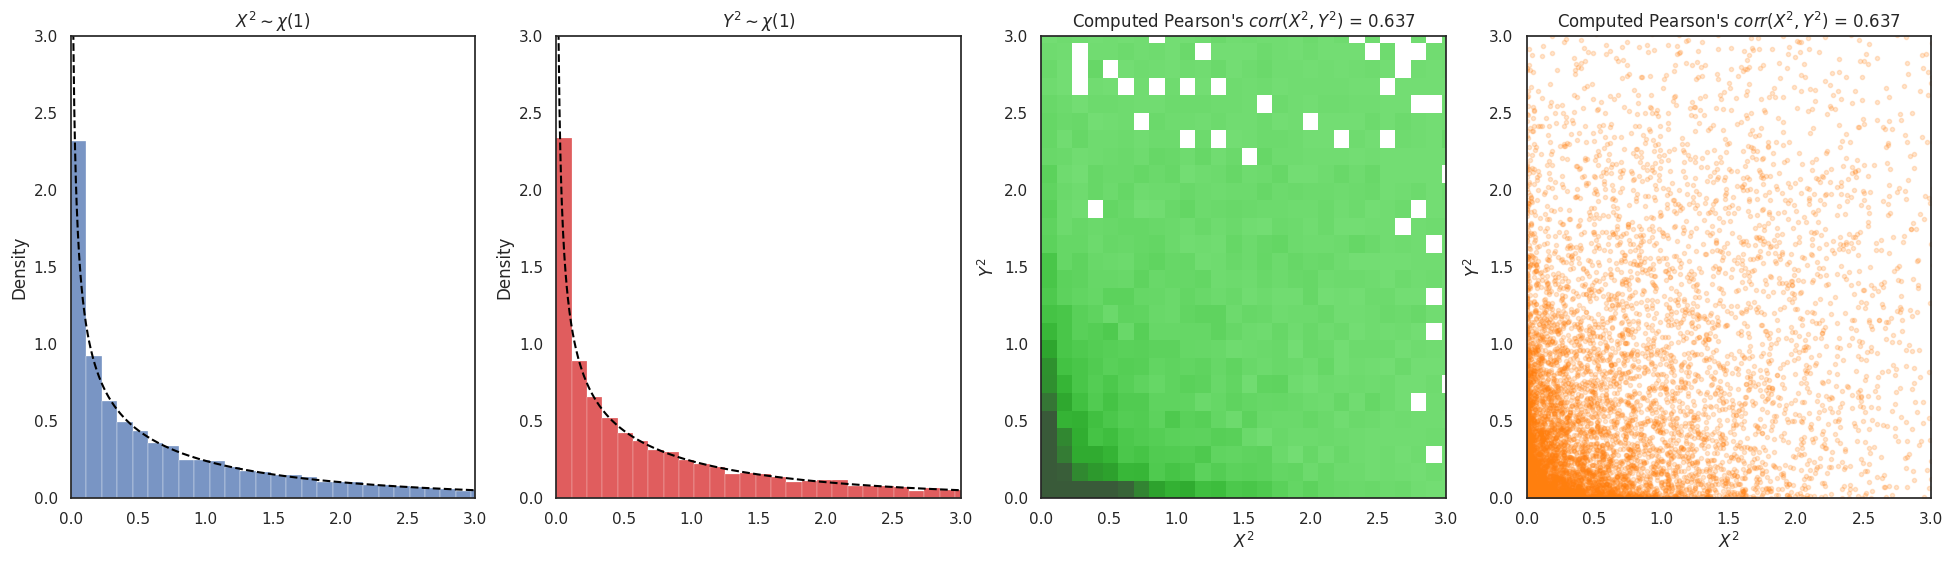

In [7]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 6), gridspec_kw={'wspace': 0.2})

# Calculate pdf for chi2 distribution
t_chi = np.linspace(0, 3, 1000)
chi2_dist = sp.stats.chi2.pdf(t_chi, 1)

# Chi2 distributions
sns.histplot(x ** 2, stat='density', ax=ax1)
ax1.plot(t_chi, chi2_dist, linestyle='--', color='black')
ax1.set_title("$X^2 \sim \chi$(1)")
ax1.set_xlim(0, 3)
ax1.set_ylim(0, 3)

sns.histplot(y ** 2, stat='density', ax=ax2, color='tab:red')
ax2.plot(t_chi, chi2_dist, linestyle='--', color='black')
ax2.set_title("$Y^2 \sim \chi$(1)")
ax2.set_xlim(0, 3)
ax2.set_ylim(0, 3)

pearson = pearsonr(x ** 2, y ** 2).statistic
sns.histplot(x=x ** 2, y=y ** 2, ax=ax3, stat='density', pmax=0.7, color="tab:green")
ax3.set_title(f"Computed Pearson's $corr(X^2,Y^2$) = {pearson:.3f}")
ax3.set_xlabel("$X^2$")
ax3.set_ylabel("$Y^2$")
ax3.set_xlim(0, 3)
ax3.set_ylim(0, 3)

ax4.plot(x ** 2, y ** 2, '.', color="tab:orange", alpha=0.2)
ax4.set_title(f"Computed Pearson's $corr(X^2,Y^2)$ = {pearson:.3f}")
ax4.set_xlabel("$X^2$")
ax4.set_ylabel("$Y^2$")
ax4.set_xlim(0, 3)
ax4.set_ylim(0, 3)

plt.show()

### Distribution of the sum of two correlated normal distributions

The second question we might ask is about the distribution of the sum $S = X^2 + Y^2$. To answer this question let's notice that:

$$
S = S_1^2(1 + r) + S_2^2(1 - r), \tag{5}
$$

where $S_1$ and $S_2$ are:

$$
S_1 = \frac{(X + Y)}{\sqrt{2(1 + r)}}, \\ S_2 = \frac{(X - Y)}{\sqrt{2(1 - r)}}
$$

It's easy to see that $S_1, S_2 \sim \mathcal{N}(0,1)$ and $\operatorname{corr}(S_1,S_2)=0$.

$$
\operatorname{Cov}(S_1, S_2) = \mathbb E[S_1S_2] - \mathbb E[S_1]\mathbb E[S_2] = \frac{\mathbb E[X^{2} - Y^{2}]}{2\sqrt{1-r^2}} = \frac{\mathbb E[X^{2}] - \mathbb E[Y^{2}]}{2\sqrt{1-r^2}} = \frac{2 - 2}{2\sqrt{1-r^2}} = 0
$$

Let's check these facts computationally

In [8]:
# Calculate S1 and S2
s1 = (x + y) / np.sqrt(2 * (1 + r))
s2 = (x - y) / np.sqrt(2 * (1 - r))

# Calculate pdf for N(0, 1) distribution
t_norm = np.linspace(-3, 3, 1000)
normal_dist = sp.stats.norm.pdf(t_norm, 0, 1)

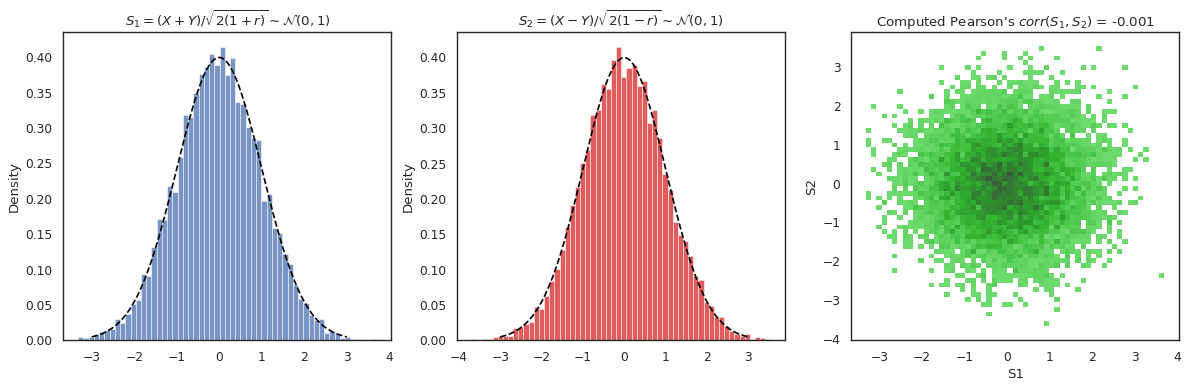

In [9]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5), gridspec_kw={'wspace': 0.2}, dpi=80)

# Plot distributions of S1 and S2
sns.histplot(s1, stat='density', ax=ax1)
ax1.plot(t_norm, normal_dist, linestyle='--', color='black')
ax1.set_title("$S_1 = (X + Y) / \sqrt{2(1 + r)} \sim \mathcal{N}(0, 1)$")

sns.histplot(s2, stat='density', ax=ax2, color="tab:red")
ax2.plot(t_norm, normal_dist, linestyle='--', color='black')
ax2.set_title("$S_2 = (X - Y) / \sqrt{2(1 - r)} \sim \mathcal{N}(0, 1)$")

pearson = pearsonr(s1, s2).statistic
sns.histplot(x=s1, y=s2, ax=ax3, stat='density', color="tab:green")
ax3.set_title(f"Computed Pearson's $corr(S_1,S_2)$ = {pearson:.3f}")
ax3.set_xlabel("S1")
ax3.set_ylabel("S2")

plt.show()

### Distribution of the sum of two Gamma distributions

In previous section we figured out that

$$
S = X^2 + Y^2 =  S_1^2(1 + r) + S_2^2(1 - r),
$$

where $S_1^2, S_2^2 \sim \chi^2(1)$. On the other hand $\chi^2(k)$ is known to be $\Gamma(\frac{k}{2}, \frac{1}{2})$. Moreover if we multiply a random variable with gamma distribution by some constant $c$ we will essentially multiply original parameter $\beta$ by $\frac{1}{c}$. So if random variable $G \sim \Gamma(\alpha, \beta)$, then random variable $T = c \cdot G \sim \Gamma(\alpha, \frac{\beta}{c})$. This means that random variable $S$ is basically a sum of two independent gamma variables:

$$
S_1^2(1 + r) \sim \Gamma(\frac{1}{2}, \frac{1}{2(1+r)}), \\
S_2^2(1 - r) \sim \Gamma(\frac{1}{2}, \frac{1}{2(1-r)}).
$$

This leads us to trying to figure out how we can sum independent gamma variables with the same $\alpha$ parameter and different $\beta$ parameters. Let's start with simple task of only 2 random variables. We want to find a distribution of variable $G = G_1 + G_2$, where $G_1 \sim \Gamma(\alpha, \beta_1)$ and $G_2 \sim \Gamma(\alpha, \beta_2)$ are independent. To answer this question we can use a convolution formula:

$$
f(g) = \int_0^gf_{g_1}(t)f_{g_2}(g - t)dt,
$$

where $f_{g_i}(\cdot)$ is a probability density function of variable $G_i$. Let's continue:

$$
f(g) = \int_0^gf_{g_1}(t)f_{g_2}(g - t)dt = \frac{(\beta_1\beta_2)^{\alpha}}{\Gamma(\alpha)^2}e^{-\beta_2g}\int^g_0t^{\alpha-1}(g - t)^{\alpha-1}e^{-(\beta_1-\beta_2)t}dt \stackrel{t=ug}{=} \frac{(\beta_1\beta_2)^{\alpha}}{\Gamma(\alpha)^2}e^{-\beta_2g}g^{2\alpha - 1}\int^1_0u^{\alpha-1}(1 - u)^{\alpha-1}e^{-(\beta_1-\beta_2)gu}du = \frac{(\beta_1\beta_2)^{\alpha}}{\Gamma(\alpha)^2}e^{-\beta_2g} g^{2\alpha - 1} \cdot \frac{\Gamma(\alpha)\Gamma(\alpha)}{\Gamma(2\alpha)}{}_1F_1\Bigl(\alpha, 2\alpha, (\beta_2 - \beta_1)g\Bigr),
$$

where ${}_1F_1$ is a [confluent hypegreometric function](https://en.wikipedia.org/wiki/Confluent_hypergeometric_function). For ${}_1F_1$ it is known that

$$
{}_1F_1(a, 2a, x) = e^{x/2}\Bigl(\frac{x}{4}\Bigr)^{\frac{1}{2} - a}\Gamma(a + 1/2)I_{a-1/2}\Bigl(\frac{x}{2}\Bigr),
$$

where $I_{a-1/2}\Bigl(\frac{x}{2}\Bigr)$ is a [Bessel function](https://en.wikipedia.org/wiki/Bessel_function). So the final result for $f(g)$ is

$$
f(g) = \frac{(\beta_1\beta_2)^{\alpha}}{\Gamma(2\alpha)}g^{2\alpha - 1}e^{-\frac{\beta_1 + \beta_2}{2}g} \Bigl(\frac{(\beta_2 - \beta_1)g}{4}\Bigr)^{\frac{1}{2} - \alpha}\Gamma(\alpha + 1/2)I_{\alpha-1/2}\Bigl(\frac{(\beta_2 - \beta_1)g}{2}\Bigr). \tag{6}
$$

Let's validate this result computationaly.

In [10]:
def sumgamma_pdf_hyp1f1(alpha, beta1, beta2, t):
    """
    Calculates the pdf of sum of two independent gamma variables using confluent hypergeometric function.
    """
    return (beta1 * beta2) ** alpha / sp.special.gamma(2 * alpha) * t ** ( 2 * alpha - 1) * np.exp(-beta2 * t) * sp.special.hyp1f1(alpha, 2 * alpha, (beta2 - beta1) * t)


def sumgamma_pdf_bessel(alpha, beta1, beta2, t):
    """
    Calculates the pdf of sum of two independent gamma variables using bessel function.
    """
    return (beta1 * beta2) ** alpha / sp.special.gamma(2 * alpha) * t ** ( 2 * alpha - 1) * np.exp(-(beta1 + beta2) * t / 2) * ((beta2 - beta1) * t / 4)**(0.5 - alpha) * sp.special.gamma(alpha + 0.5) * sp.special.iv(alpha - 0.5, (beta2 - beta1) * t / 2)


def hyp1f1_b2a(a, x):
    """
    Calculates the confluent hypergeometric function using bessel function.
    """
    return np.exp(x / 2) * (x / 4)**(0.5 - a) * sp.special.gamma(a + 0.5) * sp.special.iv(a - 0.5, x / 2)

In [11]:
# Fix parameters
alpha = 1
beta1 = 1
beta2 = 2

# Generate random variables
g1 = np.random.gamma(alpha, 1 / beta1, 50000)
g2 = np.random.gamma(alpha, 1 / beta2, 50000)
g = g1 + g2

# Calculate pdf for each variable
t = np.linspace(0, 10, 1000)
g1_dist = sp.stats.gamma.pdf(t, alpha, 0, 1 / beta1)
g2_dist = sp.stats.gamma.pdf(t, alpha, 0, 1 / beta2)
g_dist_confluent = sumgamma_pdf_hyp1f1(alpha, beta1, beta2, t)
g_dist_bessel = sumgamma_pdf_bessel(alpha, beta1, beta2, t)

/tmp/ipython-input-10-3689611283.py:12: RuntimeWarning: divide by zero encountered in power
  return (beta1 * beta2) ** alpha / sp.special.gamma(2 * alpha) * t ** ( 2 * alpha - 1) * np.exp(-(beta1 + beta2) * t / 2) * ((beta2 - beta1) * t / 4)**(0.5 - alpha) * sp.special.gamma(alpha + 0.5) * sp.special.iv(alpha - 0.5, (beta2 - beta1) * t / 2)
/tmp/ipython-input-10-3689611283.py:12: RuntimeWarning: invalid value encountered in multiply
  return (beta1 * beta2) ** alpha / sp.special.gamma(2 * alpha) * t ** ( 2 * alpha - 1) * np.exp(-(beta1 + beta2) * t / 2) * ((beta2 - beta1) * t / 4)**(0.5 - alpha) * sp.special.gamma(alpha + 0.5) * sp.special.iv(alpha - 0.5, (beta2 - beta1) * t / 2)


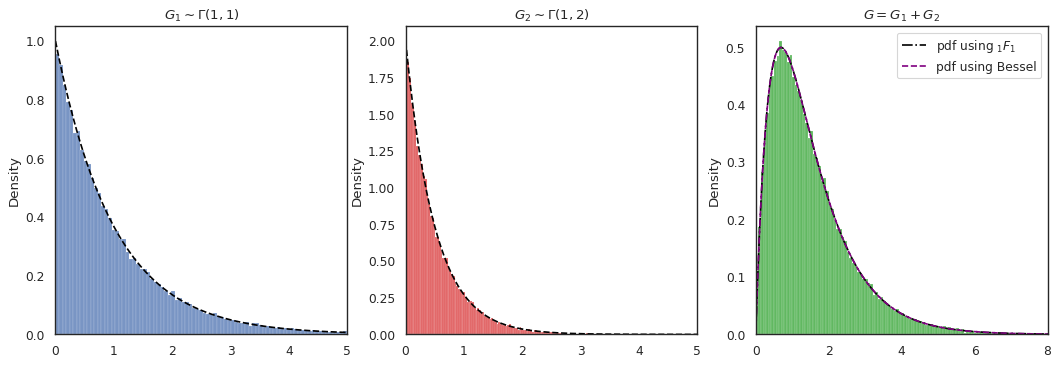

In [12]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 5), gridspec_kw={'wspace': 0.2}, dpi=80)

# Plot histograms
sns.histplot(g1, stat='density', ax=ax1)
ax1.plot(t, g1_dist, linestyle='--', color='black')
ax1.set_title(f"$G_1 \sim \Gamma({alpha}, {beta1})$")
ax1.set_xlim(0, 5)

sns.histplot(g2, stat='density', ax=ax2, color='tab:red')
ax2.plot(t, g2_dist, linestyle='--', color='black')
ax2.set_title(f"$G_2 \sim \Gamma({alpha}, {beta2})$")
ax2.set_xlim(0, 5)

sns.histplot(g, stat='density', ax=ax3, color="tab:green")
ax3.plot(t, g_dist_confluent, linestyle='-.', color='black', label="pdf using ${}_1F_1$")
ax3.plot(t, g_dist_bessel, linestyle='--', color='purple', label="pdf using Bessel")
ax3.legend()
ax3.set_title(f"$G = G_1 + G_2$")
ax3.set_xlim(0, 8)

plt.show()

Now we can finally look at the distribution of $S$. For reminder $S = X^2 + Y^2 =  S_1^2(1 + r) + S_2^2(1 - r)$ is a sum of two independet random variables with gamma distribution:

$$
S_1^2(1 + r) \sim \Gamma(\frac{1}{2}, \frac{1}{2(1+r)}), \\
S_2^2(1 - r) \sim \Gamma(\frac{1}{2}, \frac{1}{2(1-r)}).
$$

In [13]:
# Our random variables
g1 = s1 ** 2 * (1 + r)
g2 = s2 ** 2 * (1 - r)
s = g1 + g2

# Calculate pdf for each variable
t = np.linspace(0, 10, 1000)
g1_dist = sp.stats.gamma.pdf(t, 0.5, 0, 2 * (1 + r))
g2_dist = sp.stats.gamma.pdf(t, 0.5, 0, 2 * (1 - r))
s_dist = sumgamma_pdf_hyp1f1(0.5,  1 / (2 * (1 + r)), 1 / (2 * (1 - r)), t)

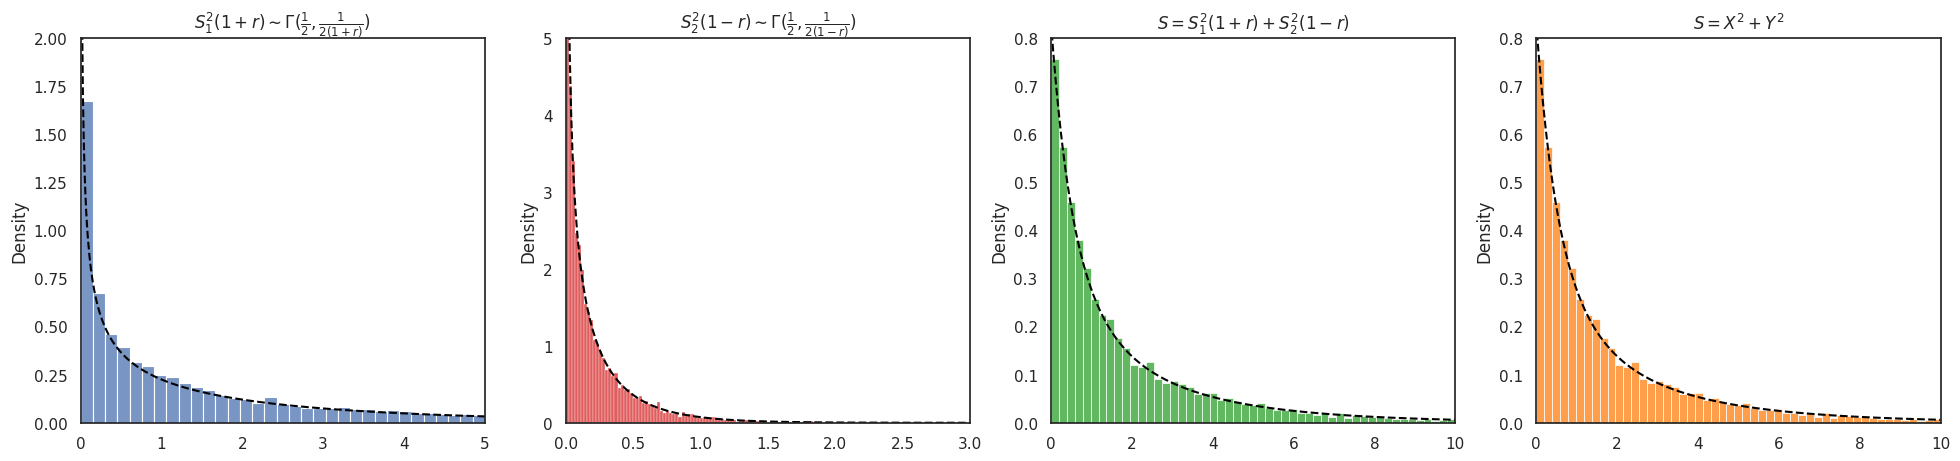

In [14]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 5), gridspec_kw={'wspace': 0.2})

# Plot histograms
sns.histplot(g1, stat='density', ax=ax1, binrange=[0, 5])
ax1.plot(t, g1_dist, linestyle='--', color='black')
ax1.set_title("$S_1^2(1 + r) \sim \Gamma(\\frac{1}{2}, \\frac{1}{2(1+r)})$")
ax1.set_xlim(0, 5)
ax1.set_ylim(0, 2)

sns.histplot(g2, stat='density', ax=ax2, color='tab:red')
ax2.plot(t, g2_dist, linestyle='--', color='black')
ax2.set_title("$S_2^2(1 - r) \sim \Gamma(\\frac{1}{2}, \\frac{1}{2(1-r)})$")
ax2.set_xlim(0, 3)
ax2.set_ylim(0, 5)

sns.histplot(g1 + g2, stat='density', ax=ax3, binrange=[0, 10], color="tab:green")
ax3.plot(t, s_dist, linestyle='--', color='black')
ax3.set_title("$S = S_1^2(1 + r) + S_2^2(1 - r)$")
ax3.set_xlim(0, 10)
ax3.set_ylim(0, 0.8)

sns.histplot(x ** 2 + y ** 2, stat='density', ax=ax4, binrange=[0, 10], color="tab:orange")
ax4.plot(t, s_dist, linestyle='--', color='black')
ax4.set_title("$S = X^2 + Y^2$")
ax4.set_xlim(0, 10)
ax4.set_ylim(0, 0.8)

plt.show()

### Sample variance of size 2

Unfortunately this won't help us analyse equation (4) as it takes the following form when n=2:

$$
\frac{\sum_{i=1}^2(X_i - \overline{X_n})^2}{\sigma^2} = \sum_{i=1}^n\Bigl(\frac{X_i - \frac{1}{2}(X_1 + X_2)}{\sigma}\Bigr)^2 = \frac{(X_1 - X_2)^2 + (X_2 - X_1)^2)}{4\sigma^2} =  \sum_{i=1}^2\Bigl(\frac{(-1)^i(X_1 - X_2)}{2\sigma}\Bigr)^2 = \sum_{i=1}^2Y_i^2.
$$

In this case we see that this sum is just two squared normal distributions with $Y_i \sim \mathcal{N}(0, \frac{1}{2})$, which is the same as taking a square of $\sqrt{2}Y_i \sim \mathcal{N}(0, 1)$. This leads us to

$$
\frac{\sum_{i=1}^2(X_i - \overline{X_n})^2}{\sigma^2} = \sum_{i=1}^2Y_i^2 = (\sqrt{2}Y_i)^2 \sim \chi^2(1).
$$

Here we basecally see equation (5) for the case of $r=-1$. Let's look at equation (5) for a range of values of $r$.

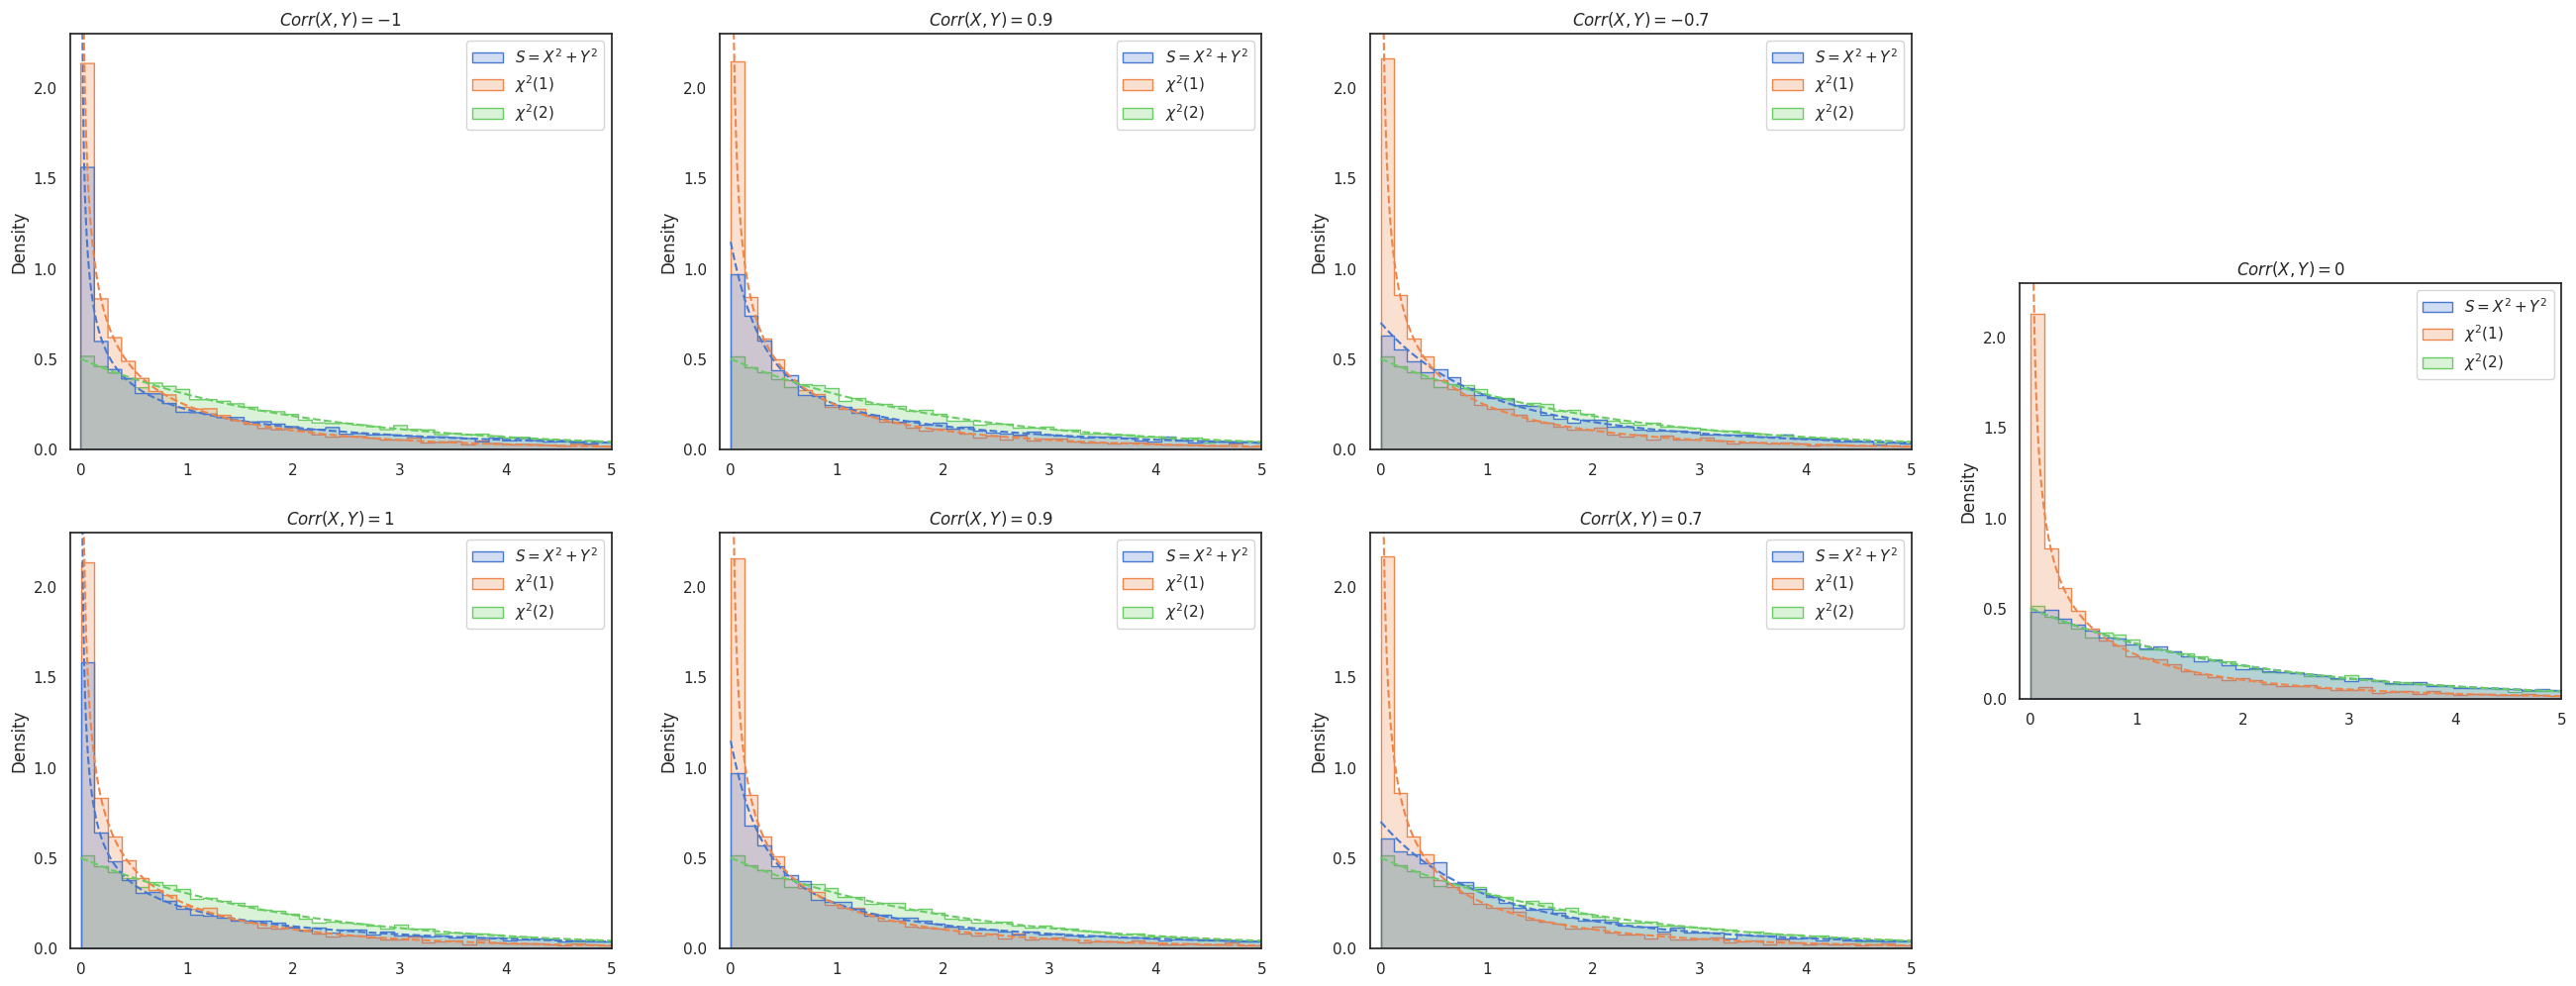

In [15]:
fig, axes = odd_subplots(7, figsize=(24, 12), gridspec_kw={'wspace': 0.2})

# fix variables
t = np.linspace(0, 10, 1000)
r_list = [-1, 0.9, -0.7, 1, 0.9, 0.7, 0]
palette = sns.color_palette("muted", 3)

# generate chi2 distribution
chi2_1 = np.random.chisquare(1, 10000)
chi2_2 = np.random.chisquare(2, 10000)
chi2_1_dist = sp.stats.chi2.pdf(t, 1)
chi2_2_dist = sp.stats.chi2.pdf(t, 2)

for r, ax in zip(r_list, axes):
    # generate X and Y variables and calculate pdf
    x = np.random.standard_normal(10000)
    y = np.random.normal(r * x, np.sqrt(1 - r ** 2))
    s = x ** 2 + y ** 2
    s_dist = sumgamma_pdf_hyp1f1(0.5,  1 / (2 * (1 + r)), 1 / (2 * (1 - r)), t) if r ** 2 != 1 else sp.stats.gamma.pdf(t, 0.5, 0, 4)

    # combine s and chi2 for visualisation
    values = np.hstack([s, chi2_1, chi2_2])
    hue = ["$S = X^2 + Y^2$"] * s.size + ["$\chi^2(1)$"] * chi2_1.size + ["$\chi^2(2)$"] * chi2_2.size

    # plot histograms
    sns.histplot(x=values, hue=hue, stat='density', multiple="layer", common_norm=False, ax=ax, element="step", palette=palette)

    # plot pdfs
    ax.plot(t, s_dist, linestyle='--', color=palette[0], label="pdf $\chi^2(2)$")
    ax.plot(t, chi2_1_dist, linestyle='--', color=palette[1], label="pdf $\chi^2(1)$")
    ax.plot(t, chi2_2_dist, linestyle='--', color=palette[2], label="pdf $\chi^2(2)$")

    # Configure axis
    ax.set_title(f"$Corr(X,Y)={r}$")
    ax.set_xlim(-0.1, 5)
    ax.set_ylim((0, 2.3))

## More correlated normal distributions

### Visualize

### Sum of correlated normal distributions

### Sum of Gamma distributions

In [16]:
def pdf_sum_gamma3(x, alpha, beta1, beta2, beta3):
    """
    Calculates pdf of  G = G1+G2+G3 by integrating over simplex
    """
    pref = (beta1*beta2*beta3)**alpha / sp.special.gamma(alpha) ** 3 * x ** (3 * alpha - 1)

    def integrand(v, u):
        w = 1 - u - v         # 3rd simplex coordinate
        if w <= 0:            # outside of the triangle of integration
            return 0.0
        return (
            u ** (alpha - 1) * v **(alpha - 1) * w **(alpha-1) *
            np.exp(- x * (beta1 * u + beta2 * v + beta3 * w))
        )

    # limits: u∈[0,1], v∈[0,1-u]
    val, _ = sp.integrate.dblquad(integrand, 0.0, 1.0, lambda u: 0.0, lambda u: 1.0 - u)

    return pref * val

In [17]:
# Fix parameters
alpha = 1
beta1 = 1
beta2 = 2
beta3 = 3

# Generate random variables
g1 = np.random.gamma(alpha, 1 / beta1, 50000)
g2 = np.random.gamma(alpha, 1 / beta2, 50000)
g3 = np.random.gamma(alpha, 1 / beta3, 50000)
g = g1 + g2 + g3

# Calculate pdf
t = np.linspace(0, 8, 200)
g1_dist = sp.stats.gamma.pdf(t, alpha, 0, 1 / beta1)
g2_dist = sp.stats.gamma.pdf(t, alpha, 0, 1 / beta2)
g3_dist = sp.stats.gamma.pdf(t, alpha, 0, 1 / beta3)
g_dist = [pdf_sum_gamma3(x, alpha, beta1, beta2, beta3) for x in t]

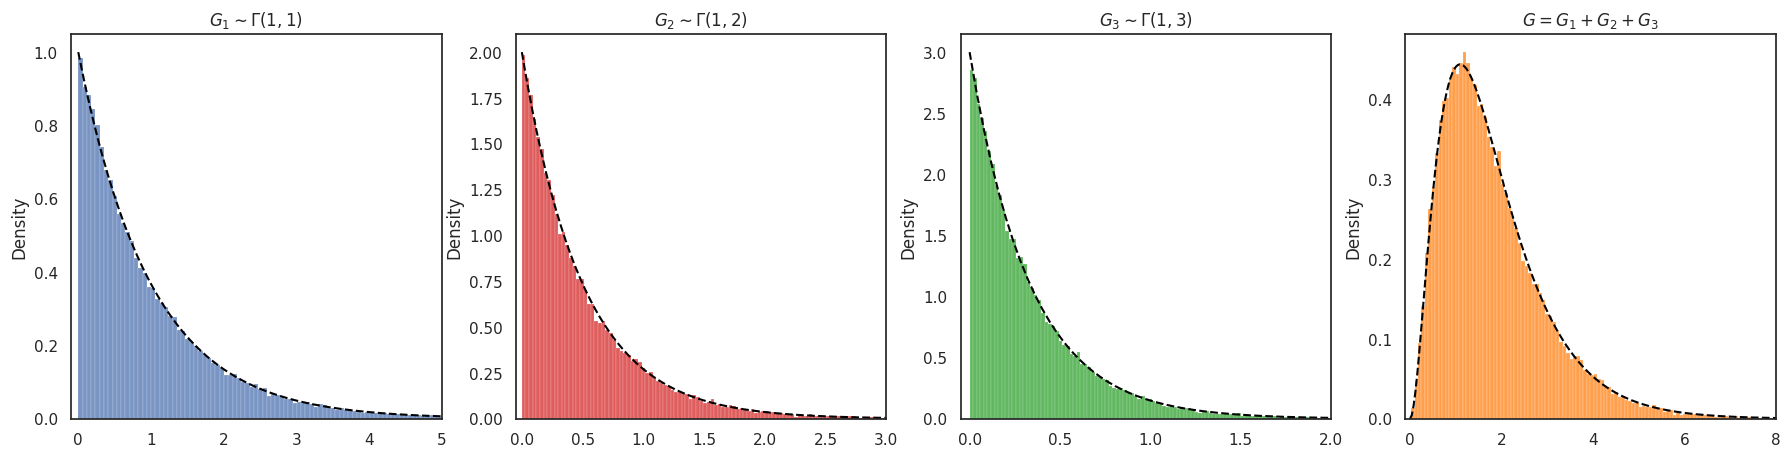

In [18]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(22, 5), gridspec_kw={'wspace': 0.2})

sns.histplot(g1, stat='density', ax=ax1)
ax1.plot(t, g1_dist, linestyle='--', color='black')
ax1.set_title(f"$G_1 \sim \Gamma({alpha}, {beta1})$")
ax1.set_xlim(-0.1, 5)

sns.histplot(g2, stat='density', ax=ax2, color='tab:red')
ax2.plot(t, g2_dist, linestyle='--', color='black')
ax2.set_title(f"$G_2 \sim \Gamma({alpha}, {beta2})$")
ax2.set_xlim(-0.05, 3)

sns.histplot(g3, stat='density', ax=ax3, color='tab:green')
ax3.plot(t, g3_dist, linestyle='--', color='black')
ax3.set_title(f"$G_3 \sim \Gamma({alpha}, {beta3})$")
ax3.set_xlim(-0.05, 2)

sns.histplot(g, stat='density', ax=ax4, color="tab:orange")
ax4.plot(t, g_dist, linestyle='--', color='black')
ax4.set_title(f"$G = G_1 + G_2 + G_3$")
ax4.set_xlim(-0.1, 8)

plt.show()